# Loading the data

In [1]:
import json

with open('data/pizza_request_dataset.json', 'r') as f:
    requests = json.load(f)

# Initial insights

In [2]:
import spacy

nlp = spacy.load('en')

In [3]:
%time request_text = [nlp(r['request_text_edit_aware']) for r in requests]

CPU times: user 41.1 s, sys: 240 ms, total: 41.3 s
Wall time: 41.8 s


## Unique grams

In [4]:
# List of words in a sentence to all ngrams
def ngrams(words, n):
    words = [w.strip().lower() for w in words]
    return list(zip(*[words[i:] for i in range(n)]))

# SpaCy sentence to words in sentence as strings
def get_words(sentence):
    return list(w.string for w in sentence if w.is_alpha)

# Get all ngrams from a SpaCy corpus
def get_request_ngrams(request, n):
    return [gram for sent in request.sents for gram in ngrams(get_words(sent), n)]

# Get all ngrams from a list of SpaCy corpora
def get_all_ngrams(request_text, n):
    grams = set()
    for text in request_text:
        grams.update(get_request_ngrams(text, n))
    return grams

In [5]:
for k in [1, 2, 3]:
    grams = get_all_ngrams(request_text, k)
    print('{0}: {1}'.format(k, len(grams)))

1: 13295
2: 110945
3: 236221


## Most frequent trigram

In [6]:
from collections import defaultdict

doc_counts = defaultdict(int)

for text in request_text:
    request_trigrams = set(get_request_ngrams(text, 3))
    for tri in request_trigrams:
        doc_counts[tri] += 1
        
max((v, k) for k, v in doc_counts.items())

(538, ('pay', 'it', 'forward'))

# Pizza modifiers

In [7]:
def get_children_pos(token, pos):
    return [t for t in token.children if t.pos_ == pos]

pizza_mod_adj = defaultdict(int)
pizza_mod_vb = defaultdict(int)

for text in request_text:
    for sent in text.sents:
        for token in sent:
            if 'pizza' in token.string.strip().lower():
                for mod_token in get_children_pos(token, 'ADJ'):
                    pizza_mod_adj[mod_token.string.strip().lower()] += 1
                for mod_token in get_children_pos(token, 'VERB'):
                    pizza_mod_vb[mod_token.lemma_] += 1

In [8]:
sorted((v, k) for k, v in pizza_mod_vb.items() if v > 10)

[(11, 'go'), (11, 'help'), (12, 'get'), (15, 'will'), (22, 'have'), (67, 'be')]

In [9]:
sorted((v, k) for k, v in pizza_mod_adj.items() if v > 10)

[(11, 'cheesy'),
 (11, 'little'),
 (11, 'simple'),
 (12, 'tasty'),
 (12, 'yummy'),
 (20, 'good'),
 (20, 'random'),
 (21, 'small'),
 (27, 'warm'),
 (30, 'large'),
 (30, 'my'),
 (45, 'hot'),
 (50, 'nice'),
 (52, 'delicious'),
 (65, 'free')]

# Going deeper

## Embeddings

In [10]:
pizza = nlp('pizza')
unigrams = get_all_ngrams(request_text, 1)
sims = {w[0]: pizza.similarity(nlp(w[0])) for w in unigrams}

In [11]:
for word, sim in sims.items():
    if sim > 0.7:
        print('{0:<12} {1:.4f}'.format(word, sim))

pizza        1.0000
burgers      0.7090
sandwich     0.7160
pasta        0.7370
burger       0.7270
sandwiches   0.7252


## TF-IDF

In [21]:
import numpy as np

def idf(request_text, n):
    N = len(request_text)
    nt = defaultdict(int)
    for text in request_text:
        for g in set(get_request_ngrams(text, n)):
            nt[g] += 1
    all_grams = get_all_ngrams(request_text, n)
    return {g: np.log(float(N) / nt[g]) for g in all_grams}
    
unigram_idfs = idf(request_text, 1)

In [22]:
from collections import Counter

def tf(text, n):
    D = sum(len(s) for s in text.sents)
    tfs = Counter(get_request_ngrams(text, n))
    return {g: float(v) / D for g, v in tfs.items()}
    
unigram_tf = tf(request_text[0], 1)

In [23]:
tf_idf = {w: unigram_tf[w] * unigram_idfs[w] for w in unigram_tf}
for w, v in tf_idf.items():
    print('{0:<16}{1:.4f}'.format(str(w), v))

('i',)          0.0144
('not',)        0.0153
('in',)         0.0094
('college',)    0.0141
('or',)         0.0186
('a',)          0.0072
('starving',)   0.0186
('artist',)     0.0291
('anything',)   0.0124
('like',)       0.0186
('that',)       0.0185
('just',)       0.0118
('been',)       0.0073
('bit',)        0.0159
('unlucky',)    0.0394
('lately',)     0.0222
('year',)       0.0148
('old',)        0.0160
('single',)     0.0226
('guy',)        0.0202
('with',)       0.0183
('job',)        0.0104
('but',)        0.0048
('rent',)       0.0147
('and',)        0.0047
('other',)      0.0144
('bills',)      0.0154
('killed',)     0.0372
('me',)         0.0145
('this',)       0.0162
('month',)      0.0134
('thought',)    0.0172
('had',)        0.0188
('enough',)     0.0141
('funds',)      0.0199
('my',)         0.0044
('account',)    0.0139
('to',)         0.0060
('at',)         0.0154
('least',)      0.0195
('keep',)       0.0178
('set',)        0.0267
('noodles',)    0.0211
('forgot',)

## Using sklearn

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

g = TfidfVectorizer()

In [13]:
def request_to_string(request):
    return ' '.join(word.text for sent in request.sents for word in sent)

In [14]:
U = g.fit_transform(request_to_string(text) for text in request_text)

In [15]:
U.shape

(5671, 14626)

In [24]:
first_request_unigrams = get_request_ngrams(request_text[0], 1)

manual_tfidfs = []
sklearn_tfidfs = []

for gram in first_request_unigrams:
    gram_text = gram[0]
    if gram_text in g.vocabulary_:
        print('{0:<16}{1:.4f}'.format(gram_text, U[0, g.vocabulary_[gram_text]]))
        sklearn_tfidfs.append(U[0, g.vocabulary_[gram_text]])
        manual_tfidfs.append(unigram_tf[gram] * unigram_idfs[gram])

not             0.0980
in              0.0964
college         0.0730
or              0.1100
starving        0.0900
artist          0.1278
or              0.1100
anything        0.0669
like            0.1104
that            0.1303
just            0.0849
been            0.0479
bit             0.0800
unlucky         0.1636
lately          0.1032
year            0.0755
old             0.0802
single          0.1050
guy             0.0953
with            0.1296
job             0.0594
but             0.0383
rent            0.0755
and             0.0991
other           0.0743
bills           0.0781
killed          0.1568
me              0.1153
this            0.1218
month           0.0704
thought         0.0849
had             0.1112
enough          0.0732
funds           0.0948
in              0.0964
my              0.0572
account         0.0723
to              0.1041
at              0.0982
least           0.0934
keep            0.0870
me              0.1153
set             0.1189
with       

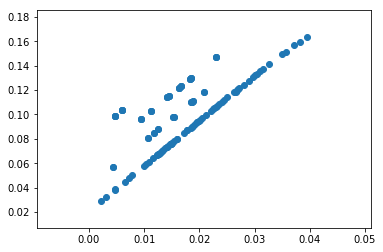

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.scatter(manual_tfidfs, sklearn_tfidfs)
plt.show()